In [1]:
# libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import tensorflow as tf
from tensorflow import keras
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

**Used defined** functions

In [2]:
# user defined function for naive forecast

def mse_average(window):
    x          = series.values
    prediction = list()
    history = [x[i] for i in range(window)]
    test    = [x[i] for i in range(window, len(x))]
    for t in range(len(test)):
        length = len(history)
        yhat = np.mean([history[i] for i in range(length-window, length)])
        obs = test[t]
        prediction.append(yhat)
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, prediction)
    #print('Test MSE: %.3f' % error)
    return error

In [3]:
# functions for grid search

# split a univariate dataset into train / test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
    return None

# forecast with a pre-fit model
def model_predict(model, history, config):
    values = list()
    for offset in config:
        values.append(history[-offset])
    return np.median(values)

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print summary
    scores_m, score_std = np.mean(scores), np.std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    plt.boxplot(scores)
    plt.show()

# transform list into supervised learning format
def series_to_supervised(data, n_in,n_out=1):
    df = DataFrame(data)
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ..., t+n)
    cols.append(df.shifht(-i))
    # put all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace = True)
    return agg.values


In [4]:
# functions for MLP model

# split a univariate dataset into train/test sets
def train_test_split_MLP(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised_MLP(data, n_in, n_out=1):
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse_MLP(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit_MLP(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised_MLP(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = keras.models.Sequential([
            keras.layers.Dense(n_nodes, activation='relu', input_dim=n_input),
            keras.layers.Dense(1)])
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict_MLP(model, history, config):
    # unpack config
    n_input, _, _, _ = config
    # prepare data
    x_input = np.array(history[-n_input:]).reshape(1, n_input)
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation_MLP(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split_MLP(data, n_test)
    # fit model
    model = model_fit_MLP(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict_MLP(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse_MLP(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate_MLP(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation_MLP(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores_MLP(name, scores):
    # print a summary
    scores_m, score_std = np.mean(scores), np.std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    plt.boxplot(scores)
    plt.show()

In [5]:
# user defined functions for CNN model

# split a univariate datset into train/test subsets
def train_test_split_CNN(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learining format
def series_to_supervised_CNN(data, n_in, n_out = 1):
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse_CNN(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit_CNN(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised_CNN(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = keras.models.Sequential([
            keras.layers.Conv1D(n_filters, n_kernel, activation = 'relu', input_shape=(n_input, 1)),
            keras.layers.Conv1D(n_filters, n_kernel, activation = 'relu'),
            keras.layers.MaxPooling1D(),
            keras.layers.Flatten(),
            keras.layers.Dense(1)])
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict_CNN(model, history, config):
    # unpack config
    n_input, _, _, _, _ = config
    # prepare data
    x_input = np.array(history[-n_input:]).reshape(1, n_input)
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation_CNN(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split_CNN(data, n_test)
    # fit model
    model = model_fit_CNN(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict_CNN(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse_CNN(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate_CNN(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation_CNN(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores_CNN(name, scores):
    # print a summary
    scores_m, score_std = np.mean(scores), np.std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    plt.boxplot(scores)
    plt.show()

In [6]:
# user defined functions for LSTM - RNN model

# split a univariate datset into train/test subsets
def train_test_split_LSTM(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learining format
def series_to_supervised_LSTM(data, n_in, n_out = 1):
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse_LSTM(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference_LSTM(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit_LSTM(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference_LSTM(train, n_diff)
    data = series_to_supervised_LSTM(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = keras.models.Sequential([
        keras.layers.LSTM(n_nodes, activation = 'relu', input_shape = (n_input, 1)),
        keras.layers.Dense(n_nodes, activation = 'relu'),
        keras.layers.Dense(1)])
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict_LSTM(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff >0:
        correction = history[-n_diff]
        history    = difference_LSTM(history, n_diff)
    x_input = np.array(history[-n_input:]).reshape(1, n_input)
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation_LSTM(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split_LSTM(data, n_test)
    # fit model
    model = model_fit_LSTM(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict_LSTM(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse_LSTM(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate_LSTM(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation_LSTM(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores_LSTM(name, scores):
    # print a summary
    scores_m, score_std = np.mean(scores), np.std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    plt.boxplot(scores)
    plt.show()

In [7]:
# user defined functions for CNN - LSTM model

# split a univariate datset into train/test subsets
def train_test_split_CNN_LSTM(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learining format
def series_to_supervised_CNN_LSTM(data, n_in, n_out = 1):
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse_CNN_LSTM(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit_CNN_LSTM(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised_CNN_LSTM(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    # define model
    model = keras.models.Sequential([
        keras.layers.TimeDistributed(keras.layers.Conv1D(n_filters, n_kernel, activation = 'relu',
                                                        input_shape=(None, n_steps, 1))),
        keras.layers.TimeDistributed(keras.layers.Conv1D(n_filters, n_kernel, activation = 'relu')),
        keras.layers.TimeDistributed(keras.layers.MaxPooling1D()),
        keras.layers.TimeDistributed(keras.layers.Flatten()),
        keras.layers.LSTM(n_nodes, activation = 'relu'),
        keras.layers.Dense(n_nodes, activation = 'relu'),
        keras.layers.Dense(1)])
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict_CNN_LSTM(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = np.array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation_CNN_LSTM(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split_CNN_LSTM(data, n_test)
    # fit model
    model = model_fit_CNN_LSTM(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict_CNN_LSTM(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse_CNN_LSTM(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate_CNN_LSTM(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation_CNN_LSTM(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores_CNN_LSTM(name, scores):
    # print a summary
    scores_m, score_std = np.mean(scores), np.std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    plt.boxplot(scores)
    plt.show()

In [8]:
# user defined functions for ConvLSTM model

# split a univariate datset into train/test subsets
def train_test_split_ConvLSTM(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learining format
def series_to_supervised_ConvLSTM(data, n_in, n_out = 1):
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse_ConvLSTM(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference_ConvLSTM(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]


# fit a model
def model_fit_ConvLSTM(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised_ConvLSTM(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
    # define model
    model = keras.models.Sequential([
        keras.layers.ConvLSTM2D(n_filters, (1, n_kernel), activation = 'relu', 
                                input_shape =(n_seq, 1, n_steps,1)),
        keras.layers.Flatten(),
        keras.layers.Dense(n_nodes, activation = 'relu'),
        keras.layers.Dense(1)])
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict_ConvLSTM(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = np.array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation_ConvLSTM(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split_ConvLSTM(data, n_test)
    # fit model
    model = model_fit_ConvLSTM(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict_ConvLSTM(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse_ConvLSTM(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate_ConvLSTM(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation_ConvLSTM(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores_ConvLSTM(name, scores):
    # print a summary
    scores_m, score_std = np.mean(scores), np.std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    plt.boxplot(scores)
    plt.show()

**Loading** dataset

In [9]:
# loading dataset

dataset = pd.read_csv('.//datasets/monthly-car-sales.csv')
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset['Sales'] = dataset['Sales'].astype(float)
dataset.head()

,Month,Sales
0,1960-01-01,6550.0
1,1960-02-01,8728.0
2,1960-03-01,12026.0
3,1960-04-01,14395.0
4,1960-05-01,14587.0


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   108 non-null    datetime64[ns]
 1   Sales   108 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB


Figure: Monthly car sales in Quebec from 1960 to 1968.


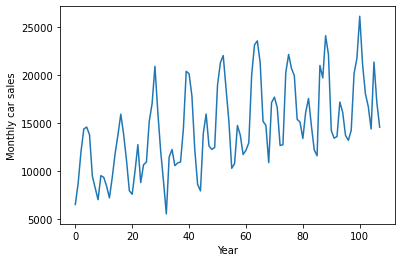

In [11]:
# visualize the univariate data
data = dataset['Sales']

# visualize the data
ax = data.plot()
ax.set_xlabel('Year')
ax.set_ylabel('Monthly car sales')
print("Figure: Monthly car sales in Quebec from 1960 to 1968.")

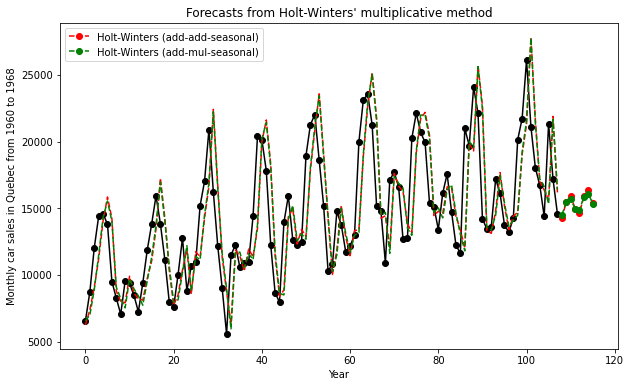

Figure 7.6: Forecasting Monthly car sales in Quebec from 1960 to 1968 using Holt-Winters method with both additive and multiplicative seasonality.


In [12]:
# fitting data for Additive method
fit1 = ExponentialSmoothing(data, seasonal_periods = 4, trend = 'add', seasonal = 'add',
                           use_boxcox = True, initialization_method = 'estimated').fit()

# fitting data for Multiplicative method
fit2 = ExponentialSmoothing(data, seasonal_periods = 4, trend = 'add', seasonal = 'mul',
                           use_boxcox = True, initialization_method = 'estimated').fit()

# visualizing the smoothed trends
ax = data.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",)
ax.set_ylabel("Monthly car sales in Quebec from 1960 to 1968")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style="--", color="red")
fit2.fittedvalues.plot(ax=ax, style="--", color="green")

fit1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True)
fit2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True)

plt.show()
print(
    "Figure 7.6: Forecasting Monthly car sales in Quebec from 1960 to 1968 using Holt-Winters method with both additive and multiplicative seasonality.")



In [13]:
# naive forecast
# loading the dataset
series = pd.read_csv('.//datasets/monthly-car-sales.csv', header = 0, index_col = 0)

# tail-rolling average transform
rolling = series.rolling(window=3)
rolling_mean = rolling.mean()

# parameters
max_window    = 60
num_step      = list()
error_list    = list()
min_error     = 0
optimal_steps = 0

for i in range(max_window):
    window = i + 1
    error_window= mse_average(window)
    num_step.append(window)
    error_list.append(error_window)
    if error_window == np.min(error_list):
        min_error = error_window
        optimal_steps = window
        
# optimal model for naive average forecast
mse_naive_trend = np.sqrt(min_error)
print(f"""Mean Squeared Error Additive trend: {mse_naive_trend}""")

Mean Squeared Error Additive trend: 3313.6035879866135


In [14]:
# making predictions using Holt Winter's method trend and seasonality

# fitting data for Additive method
fit2 = ExponentialSmoothing(data, seasonal_periods = 4, trend = 'add', seasonal = 'add',
                           use_boxcox = True, initialization_method = 'estimated').fit()

# fitting data for Multiplicative method
fit3 = ExponentialSmoothing(data, seasonal_periods = 4, trend = 'add', seasonal = 'mul',
                           use_boxcox = True, initialization_method = 'estimated').fit()

# fitting data for Addtivie damped method
fit4 = ExponentialSmoothing(data, seasonal_periods = 4, trend = 'add', seasonal = 'add',
                            damped_trend = True, use_boxcox = True, 
                            initialization_method = 'estimated').fit()

# fitting data for Mutiplicative damped method
fit5 = ExponentialSmoothing(data, seasonal_periods = 4, trend = 'add', seasonal = 'mul',
                            damped_trend = True, use_boxcox = True, 
                            initialization_method = 'estimated').fit()

# storing results
results = pd.DataFrame(index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"])
params = ["smoothing_level", "smoothing_trend", "damping_trend", "smoothing_seasonal",
          "initial_level", "initial_trend",]
results["Additive"] = [fit1.params[p] for p in params] + [fit2.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit3.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit4.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit5.sse]

In [15]:
# testing error for Additive trend
split_treshold = int(len(data)*0.8)

# split in train / test dataset
data_train = data[: split_treshold]
data_test = data[split_treshold :]

# defining timesteps
timesteps = len(data_test)                                                        # working with dataframes

# creating the list to store predictions
predictions_additive_trend = list()

# creating the list of predictions
for i in range(timesteps):
    data_train = data[: split_treshold+i]
    data_test = data[split_treshold+i :]
    fit_train = fit2
    forecast_train = fit_train.forecast(i+1).rename("Holt's Additive trend")
#    predictions_additive_trend.append(forecast_train)                             # working with dataframes
    
# restoring the test_dataset
data_test = data[split_treshold :]
predictions_additive_trend = forecast_train                                        # working with dataframes

# calculating the mse for the Exponential Smoothing
mse_additive_trend = np.sqrt(mean_squared_error(data_test, predictions_additive_trend))
print(f"""Mean Squeared Error Additive trend: {mse_additive_trend}""")

Mean Squeared Error Additive trend: 4362.802057857074


In [16]:
# testing error for Multiplicative trend
split_treshold = int(len(data)*0.8)

# split in train / test dataset
data_train = data[: split_treshold]
data_test = data[split_treshold :]

# defining timesteps
timesteps = len(data_test)                                                        # working with dataframes

# creating the list to store predictions
predictions_multiplicative_trend = list()

# creating the list of predictions
for i in range(timesteps):
    data_train = data[: split_treshold+i]
    data_test = data[split_treshold+i :]
    fit_train = fit3
    forecast_train = fit_train.forecast(i+1).rename("Holt's Multiplicative trend")
#    predictions_additive_trend.append(forecast_train)                             # working with dataframes
    
# restoring the test_dataset
data_test = data[split_treshold :]
predictions_multiplicative_trend = forecast_train                                        # working with dataframes

# calculating the mse for the Exponential Smoothing
mse_multiplicative_trend = np.sqrt(mean_squared_error(data_test, predictions_multiplicative_trend))
print(f"""Mean Squeared Error Multiplicative trend: {mse_multiplicative_trend}""")

Mean Squeared Error Multiplicative trend: 4355.5093350278685


In [17]:
# testing error for Additive damped trend
split_treshold = int(len(data)*0.8)

# split in train / test dataset
data_train = data[: split_treshold]
data_test = data[split_treshold :]

# defining timesteps
timesteps = len(data_test)                                                        # working with dataframes

# creating the list to store predictions
predictions_additive_damped_trend = list()

# creating the list of predictions
for i in range(timesteps):
    data_train = data[: split_treshold+i]
    data_test = data[split_treshold+i :]
    fit_train = fit4
    forecast_train = fit_train.forecast(i+1).rename("Holt's Additive trend")
#    predictions_additive_trend.append(forecast_train)                             # working with dataframes

# restoring the test_dataset
data_test = data[split_treshold :]
predictions_additive_damped_trend = forecast_train                                        # working with dataframes

# calculating the mse for the Exponential Smoothing
mse_additive_damped_trend = np.sqrt(mean_squared_error(data_test, predictions_additive_damped_trend))
print(f"""Mean Squeared Error Additive damped trend: {mse_additive_damped_trend}""")

Mean Squeared Error Additive damped trend: 4884.253029135953


In [18]:
# testing error for Multiplicative damped trend
split_treshold = int(len(data)*0.8)

# split in train / test dataset
data_train = data[: split_treshold]
data_test = data[split_treshold :]

# defining timesteps
timesteps = len(data_test)                                                        # working with dataframes

# creating the list to store predictions
predictions_multiplicative_damped_trend = list()

# creating the list of predictions
for i in range(timesteps):
    data_train = data[: split_treshold+i]
    data_test = data[split_treshold+i :]
    fit_train = fit4
    forecast_train = fit_train.forecast(i+1).rename("Holt's Multiplicative trend")
#    predictions_additive_trend.append(forecast_train)                             # working with dataframes
    
# restoring the test_dataset
data_test = data[split_treshold :]
predictions_multiplicative_damped_trend = forecast_train                                        # working with dataframes

# calculating the mse for the Simple Exponential Smoothing
mse_multiplicative_damped_trend = np.sqrt(mean_squared_error(data_test, predictions_multiplicative_damped_trend))
print(f"""Mean Squeared Error Multiplicative damped trend: {mse_multiplicative_damped_trend}""")

Mean Squeared Error Multiplicative damped trend: 4884.253029135953


In [19]:
# choosing the best Holt Winter smoothing method using data with trend and seasonality

error_smoothing = np.array([mse_naive_trend, mse_additive_trend, mse_multiplicative_trend, mse_additive_damped_trend,
                 mse_multiplicative_damped_trend])
mse = np.min(error_smoothing)
index_mse = np.argmin(error_smoothing, axis=None, out=None)
best_model = list()

if index_mse == 0: best_model = 'Naive trend'
if index_mse == 1: best_model = 'Additive trend'
if index_mse == 2: best_model = 'Multiplicative Trend'
if index_mse == 3: best_model = 'Additive Damped Trend'
if index_mse == 4: best_model = 'Multiplicative Damped Trend'
    
print('Holt Winter smoothing best method')
print(f"""The best model is : {best_model} """)
print(f"""The Mean Squared Error is: {mse}""")

Holt Winter smoothing best method
The best model is : Naive trend 
The Mean Squared Error is: 3313.6035879866135


**Sarima** model

**Naive** model

 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
persistance: 1841.156 RMSE (+/- 0.000)


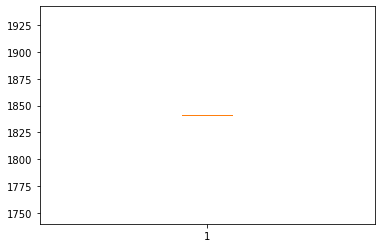

In [20]:
# summarizing scores
series = pd.read_csv('.//datasets/monthly-car-sales.csv', header = 0, index_col = 0)
data = series.values

# data split
n_test = 12

# define config
config = [12, 24, 36]

# grid search
scores = repeat_evaluate(data, config, n_test)

# summarize scores
summarize_scores('persistance', scores)

# storing the summarize
mse_naive     = np.mean(scores)
mse_dev_naive = np.std(scores)

_____________________________________________________________________________
**MLP** Multilayer Perceptron  Model

 > 1518.307
 > 1505.611
 > 1541.794
 > 1399.472
 > 1466.692
 > 1567.682
 > 1541.132
 > 1430.405
 > 1711.213
 > 1752.336
 > 1445.304
 > 1643.128
 > 1380.763
 > 1592.921
 > 1663.876
 > 1624.404
 > 1448.814
 > 1740.795
 > 1718.850
 > 1906.489
 > 1621.514
 > 1608.151
 > 1635.469
 > 1686.051
 > 1531.303
 > 1486.264
 > 1623.256
 > 1430.027
 > 1500.868
 > 1888.793
mlp: 1587.056 RMSE (+/- 131.606)


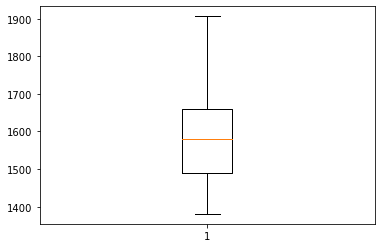

In [21]:
# reading the dataset
# series = pd.read_csv('.//datasets/monthly-car-sales.csv', header = 0, index_col = 0)
# data = series.values

# data split
n_test = 12

#define config
config = [24, 500, 100, 100]

# grid search
scores = repeat_evaluate_MLP(data, config, n_test)

# summarize scores
summarize_scores_MLP('mlp', scores)

# storing the summarize
mse_mlp     = np.mean(scores)
mse_dev_mlp = np.std(scores)

**CNN** Convolutional Neural Network

 > 1540.751
 > 1429.309
 > 1607.239
 > 1643.388
 > 1538.518
 > 1425.834
 > 1497.800
 > 1499.532
 > 1526.533
 > 1552.441
 > 1593.036
 > 1595.260
 > 1562.677
 > 1509.223
 > 1523.872
 > 1732.924
 > 1530.054
 > 1432.397
 > 1558.055
 > 1525.308
 > 1432.845
 > 1531.800
 > 1528.700
 > 1578.945
 > 1438.912
 > 1490.716
 > 1569.087
 > 1490.728
 > 1599.399
 > 1580.062
cnn: 1535.512 RMSE (+/- 67.063)


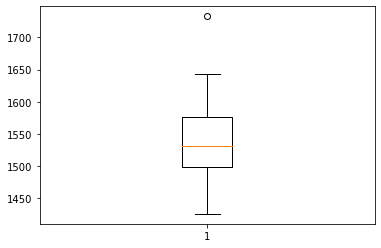

In [22]:
# using the same data object
# series = pd.read_csv('.//datasets/monthly-car-sales.csv', header = 0, index_col = 0)
# data = series.values

# data split
n_test = 12

# define config
config = [36, 256, 3, 100, 100]

# grid search
scores = repeat_evaluate_CNN(data, config, n_test)

# summarize scores
summarize_scores_CNN('cnn', scores)

# storing the summarize
mse_cnn     = np.mean(scores)
mse_dev_cnn = np.std(scores)

**LSTM** Recurrent Neural Network

 > 2559.497
 > 2068.326
 > 2120.107
 > 1906.908
 > 2061.984
 > 2138.113
 > 1989.658
 > 2109.399
 > 2271.700
 > 2050.221
 > 2204.405
 > 2115.789
 > 2240.044
 > 2054.859
 > 2034.102
 > 2164.298
 > 2179.561
 > 2092.341
 > 2163.579
 > 2097.272
 > 2053.378
 > 2116.031
 > 2516.440
 > 2256.943
 > 2052.217
 > 2063.950
 > 2104.446
 > 2201.306
 > 2018.711
 > 2079.004
lstm: 2136.153 RMSE (+/- 133.023)


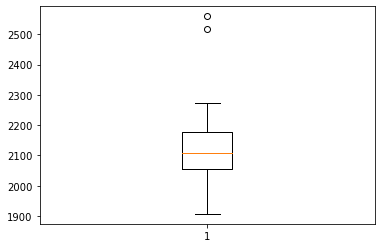

In [23]:
# using the same data object
# series = pd.read_csv('.//datasets/monthly-car-sales.csv', header = 0, index_col = 0)
# data = series.values

# data split
n_test = 12

# define config
config = [36, 50, 100, 100, 12]

# grid search
scores = repeat_evaluate_LSTM(data, config, n_test)

# summarize scores
summarize_scores_LSTM('lstm', scores)

# storing the summarize
mse_lstm     = np.mean(scores)
mse_dev_lstm = np.std(scores)

**CNN - LSTM** Convolutional - Recurrent Neural Network

 > 1447.839
 > 1423.717
 > 1713.512
 > 1621.920
 > 1312.133
 > 1565.121
 > 1614.642
 > 1707.633
 > 1291.430
 > 1854.881
 > 1452.627
 > 1479.446
 > 1611.734
 > 1548.415
 > 1615.045
 > 2471.351
 > 1399.954
 > 1704.875
 > 1389.441
 > 1625.076
 > 1494.390
 > 1761.976
 > 1655.025
 > 1557.462
 > 1608.847
 > 1455.402
 > 1869.312
 > 1719.405
 > 2005.148
 > 1416.699
lstm: 1613.149 RMSE (+/- 228.088)


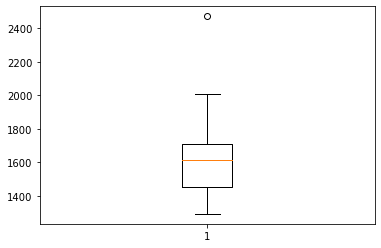

In [24]:
# using the same data object
# series = pd.read_csv('.//datasets/monthly-car-sales.csv', header = 0, index_col = 0)
# data = series.values

# data split
n_test = 12

# define config
config = [3, 12, 64, 3, 100, 200, 100]

# grid search
scores = repeat_evaluate_CNN_LSTM(data, config, n_test)

# summarize scores
summarize_scores_CNN_LSTM('lstm', scores)

# storing the summarize
mse_cnn_lstm     = np.mean(scores)
mse_dev_cnn_lstm = np.std(scores)

**ConvLSTM** Neural Network model

 > 1509.457
 > 2364.069
 > 1722.414
 > 1850.690
 > 1687.084
 > 1904.641
 > 2125.165
 > 2069.641
 > 2151.498
 > 1597.710
 > 2003.507
 > 1858.247
 > 2083.112
 > 2144.359
 > 1499.916
 > 2049.648
 > 2318.746
 > 1958.221
 > 1796.012
 > 1579.881
 > 1913.034
 > 1852.995
 > 1646.836
 > 1760.252
 > 1939.148
 > 1428.413
 > 2225.800
 > 1623.403
 > 1973.361
 > 2377.788
convlstm: 1900.502 RMSE (+/- 257.406)


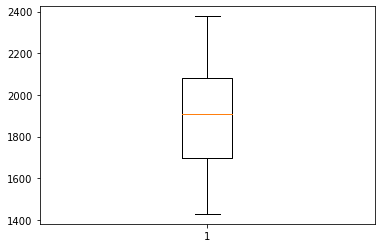

In [25]:
# using the same data object
series = pd.read_csv('.//datasets/monthly-car-sales.csv', header = 0, index_col = 0)
data = series.values

# data split
n_test = 12

# define config
config = [3, 12, 256, 3, 200, 200, 100]

# grid search
scores = repeat_evaluate_ConvLSTM(data, config, n_test)

# summarize scores
summarize_scores_ConvLSTM('convlstm', scores)

# storing the summarize
mse_convlstm     = np.mean(scores)
mse_dev_convlstm = np.std(scores)

In [26]:
np.mean(scores)

1900.501699853446

In [33]:
# choosing the best Holt Winter smoothing method using data with trend and seasonality

error_nn = np.array([mse_naive, mse_mlp, mse_cnn, mse_lstm, mse_cnn_lstm, mse_convlstm])
mse = np.min(error_nn)
index_mse = np.argmin(error_nn, axis=None, out=None)
best_model = list()
deviation = list()

if index_mse == 0: 
    best_model = 'Naive model' 
    deviation = mse_dev_naive
if index_mse == 1: 
    best_model = 'Multilayer Perceptron Neural Networl model'
    deviation = mse_dev_mlp
if index_mse == 2: 
    best_model = 'Convolutional Neural Network model'
    deviation = mse_dev_cnn
if index_mse == 3: 
    best_model = 'LSTM Recurrent Neural Network model'
    deviation = mse_dev_lstm
if index_mse == 4: 
    best_model = 'CNN - LSTM Convolutional - Recurrent Neural Network model'
    deviation = mse_dev_cnn_lstm
if index_mse == 5: 
    best_model = 'ConvLSTM Convolutional 2D Neural Network model'
    deviation = mse_dev_convlstm
    

print(f"""The best model is : {best_model} """)

print('%s: %.3f RMSE (+/- %.3f)' % (best_model, mse, deviation))

The best model is : Convolutional Neural Network model 
Convolutional Neural Network model: 1535.512 RMSE (+/- 67.063)
